<a href="https://colab.research.google.com/github/Chromathematics/Projet_Signal_ARIA_2025/blob/main/ProjetSignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Chromathematics/Projet_Signal_ARIA_2025

Cloning into 'Projet_Signal_ARIA_2025'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 74 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 3.94 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
Data_path = r"/content/Projet_Signal_ARIA_2025"

In [3]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Introduction
Voici le notebook qui met en exergue la méthode détaillée dans le rapport. Dans un premier temps, les données sont chargées dans un array. Les données mesurées mais inutiles (champs magnétique en x et y) ne sont pas enregistrées. Par la suite, les séries temporelles sont traitées une par une, car il n'a pas été trouvé d'automatisation pour corriger de manière efficace les erreurs impulsionnelles notamment. Le motif est extrait par un algorithme de distance Euclidienne normalisé pour L = 4 s, qui a présenté les meilleurs résultats. Ces motifs sont centrés et réduits pour une étude par Analyse en Composante Principale (ACP) qui cherchera à maximiser la ségrégation des données en deux classes par observable. Seul le trio déterminé  comme étant le plus efficace sera computé ici, pour retourner un fichier numpy compressé comprenant 51 données des 3 observables. Par la suite, une classification par la méthode des 2 moyens est proposée, mais elle n'est pas obligatoire.


# Chargement des données expérimentales


In [4]:
Liste2=[]
D=[f for f in os.listdir(Data_path) if f.endswith('csv')]
N=len(D) #N is the number for experiment
i=0
for name in D:
    print(f'Downloading data from experience {i}/{N}...')
    df=pandas.read_csv(f"{Data_path}/{name}",header=0)
    df.drop(['Magnetic Field x (µT)','Magnetic Field y (µT)','Absolute field (µT)'],axis=1)
    x=df['Magnetic Field z (µT)']
    t=df['Time (s)']
    x=np.array(x)
    t=np.array(t)
    Liste2.append([name,x,t])
    i+=1
Liste2=pandas.DataFrame(Liste2,columns=['name','x','t'])
print('Done !')

Done !


# Débruitement des données
Expérimentalement, l'épaulé présente un bruit impulsionnel à la décharge de la barre (c'est-à-dire après la quatrième étape d'un motif), et parfois juste avant la réception. l'arraché est un mouvement qui provoque des désequilibres qui se manifestent par un large gap des données.
## Découpage des débuts et fin de séries temporelles / concaténation
L'algorithme découpe la liste eux deux morceaux de temps : $[0,t0]$ et $[t0,N-1]$ avec N le nombre de points. On choisit alors quel fragment on conserve.  $t0$ est déterminé visuellement.
Séries 10,22,27,32

## interpolation et bruit impulsionnels
Certaines données (27,28,29,41) ont des gap de signal importants (de l'ordre de la dizaine de seconde) qui est une erreur expérimentale. D'autres présentent un bruit impulsionnel qui ne fait pas 1 point, mais 0.1 seconde. Ces données sont toutes bien corrigées par une interpolation avec un polynôme de degré 3 avec une régression sur les points précédents et suivant le gap. La méthode $\texttt{np.polyfit}$ prend en entrée la liste de points avant le gap, après le gap, et le degré du polynôme. \
Séries 3,4,8,7,9,13,16,17,21,24,25,30,33,32,35,38,42,43,45,48,51



ERROR: Operation cancelled by user
0 16_Mg_mesure.csv
1 13_Mg_mesure.csv
2 11_Mg_mesure.csv
3 5_Mg_mesure.csv
4 22_Mg_mesure.csv
5 42_Mg_mesure.csv
6 23_Mg_mesure.csv
7 38_Mg_mesure.csv
8 43_Mg_mesure.csv
9 17_Mg_mesure.csv
10 48_Mg_mesure.csv
11 33_Mg_mesure.csv
12 40_Mg_mesure.csv
13 24_Mg_mesure.csv
14 6_Mg_mesure.csv
15 28_Mg_mesure.csv


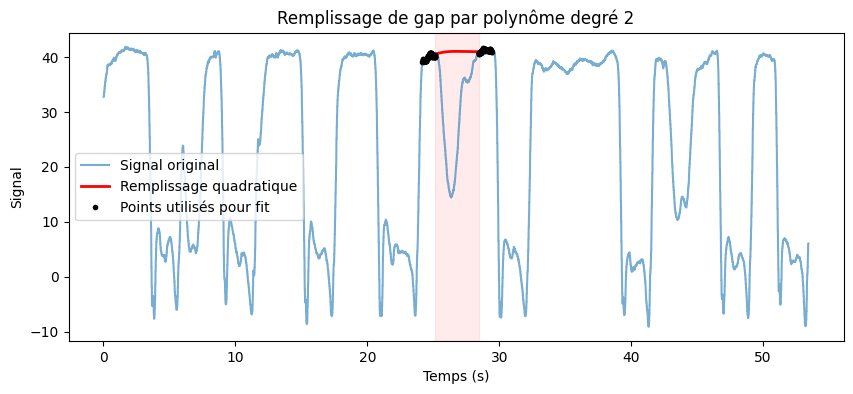

16 8_Mg_mesure.csv
17 14_Mg_mesure.csv
18 29_Mg_mesure.csv
19 46_Mg_mesure.csv
20 1_Mg_mesure.csv
21 12_Mg_mesure.csv
22 30_Mg_mesure.csv
23 51_Mg_mesure.csv
24 49_Mg_mesure.csv
25 27_Mg_mesure.csv
26 41_Mg_mesure.csv
27 9_Mg_mesure.csv
28 2_Mg_mesure.csv
29 32_Mg_mesure.csv
30 10_Mg_mesure.csv
31 37_Mg_mesure.csv
32 31_Mg_mesure.csv
33 39_Mg_mesure.csv
34 34_Mg_mesure.csv
35 19_Mg_mesure.csv
36 25_Mg_mesure.csv
37 3_Mg_mesure.csv
38 47_Mg_mesure.csv
39 7_Mg_mesure.csv
40 20_Mg_mesure.csv
41 15_Mg_mesure.csv
42 18_Mg_mesure.csv
43 36_Mg_mesure.csv
44 35_Mg_mesure.csv
45 45_Mg_mesure.csv
46 21_Mg_mesure.csv
47 44_Mg_mesure.csv
48 26_Mg_mesure.csv
49 4_Mg_mesure.csv
50 50_Mg_mesure.csv
51


In [10]:
!pip install filetype
!pip install sporco
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from sporco.admm import bpdn
import pandas

def SAMPLING(df):
    time = df['Time (s)']
    # Compute time differences between consecutive samples
    dt = time.diff().dropna()
    # Mean period
    period = dt.mean()
    # Sampling frequency
    frequency = 1.0 / period
    return period, frequency
def SAMPLINGarray(t):
    dt =np.diff(t)
    periode=np.mean(dt)
    fs=1/periode
    return(periode,fs)
def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return X,f

def fft_filter(x,t,threshold=1e5):
    X=np.fft.fft(x)
    X[np.abs(X)**2<threshold]=0 # Thresholding
    y=np.real(np.fft.ifft(X)) # Reconstruction
    return(y)
def low_pass_filter(x,fc,Fs):
    wc=fc/(Fs/2)
    b, a = signal.butter(4, wc, 'low')
    y = signal.filtfilt(b, a, x)
    return y
# Bruit Blanc
fc=1.2 #Hz
# B 1. cut of datas
def first_index(arr, value):
    n=len(arr)
    for i in range(n):
        if arr[i]> value:
            return i
    return -1  # if value not found
#Données concernées : 10,22,27,32
# B 2. Interpolation avec un polynôme d'ordre 3
def fill_gap_with_quadratic(t, x, gap_start, gap_end, Fs,
                            left_duration=5.0, right_duration=5.0,
                            method='lsq', min_points_each_side=3, plot=False):
    t = np.asarray(t)
    x = np.asarray(x)
    N = t.size

    # indices du début et fin du gap
    idx_start = np.searchsorted(t, gap_start, side='left')
    idx_end = np.searchsorted(t, gap_end, side='right')

    if idx_start >= idx_end:
        raise ValueError("gap_start doit être < gap_end et correspondre à un intervalle non vide.")

    # nombre d'échantillons à prendre autour (convertir durées -> samples)
    left_n = max(int(np.round(left_duration * Fs)), min_points_each_side)
    right_n = max(int(np.round(right_duration * Fs)), min_points_each_side)

    # indices de fenêtres (sans chevauchement dans le gap)
    left_inds = np.arange(max(0, idx_start - left_n), idx_start)
    right_inds = np.arange(idx_end, min(N, idx_end + right_n))

    # si fenêtre vide -> essayer d'élargir ou lever erreur
    if left_inds.size < min_points_each_side or right_inds.size < min_points_each_side:
        # essayer d'élargir uniformément si possible
        extra = min_points_each_side
        left_inds = np.arange(max(0, idx_start - left_n - extra), idx_start)
        right_inds = np.arange(idx_end, min(N, idx_end + right_n + extra))

    # méthode LSQ (régression sur les points voisins)
    if method == 'lsq':
        fit_inds = np.concatenate((left_inds, right_inds))
        if fit_inds.size < 3:
            raise ValueError("Pas assez de points propres autour du gap pour faire une régression quadratique.")
        t_fit = t[fit_inds]
        x_fit = x[fit_inds]
        # robust check: enlever NaN / Inf si présents
        good = np.isfinite(t_fit) & np.isfinite(x_fit)
        t_fit = t_fit[good]
        x_fit = x_fit[good]
        if t_fit.size < 3:
            raise ValueError("Après suppression des NaN/Inf, pas assez de points pour fit.")
        # fit polynôme degré 3
        p = np.polyfit(t_fit, x_fit, 3)
    elif method == '3pt':
        # Utiliser 3 points (par ex. 2 derniers avant + 1er après) ou autre combinaison
        if left_inds.size >= 2 and right_inds.size >= 1:
            pts = np.array([left_inds[-2], left_inds[-1], right_inds[0]])
        elif left_inds.size >=1 and right_inds.size >=2:
            pts = np.array([left_inds[-1], right_inds[0], right_inds[1]])
        else:
            raise ValueError("Pas assez de points pour la méthode 3pt.")
        t_fit = t[pts]
        x_fit = x[pts]
        p = np.polyfit(t_fit, x_fit, 2)
    else:
        raise ValueError("method doit être 'lsq' ou '3pt'")

    # évaluer sur le gap
    t_gap = t[idx_start:idx_end]
    x_gap = np.polyval(p, t_gap)

    # construire le signal rempli
    x_filled = x.copy()
    x_filled[idx_start:idx_end] = x_gap

    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(t, x, label='Signal original', alpha=0.6)
        plt.plot(t[idx_start:idx_end], x_gap, 'r', lw=2, label='Remplissage quadratique')
        plt.axvspan(gap_start, gap_end, color='red', alpha=0.08)
        # afficher les points de fit
        if method == 'lsq':
            plt.plot(t_fit, x_fit, 'ko', markersize=3, label='Points utilisés pour fit')
        else:
            plt.plot(t_fit, x_fit, 'go', markersize=6, label='3 points utilisés')
        plt.legend()
        plt.xlabel('Temps (s)')
        plt.ylabel('Signal')
        plt.title('Remplissage de gap par polynôme degré 2')
        plt.show()
    return x_filled, p, idx_start, idx_end
Liste3=[]
N=len(Liste2)
for i in range(N):
    name = Liste2['name'].iloc[i]
    print(i,name)
    x_fill=Liste2['x'].iloc[i]
    t=Liste2['t'].iloc[i]
    _,Fs=SAMPLINGarray(t)
    if name=='10_Mg_mesure.csv':
        t0=first_index(t,33.0)
        x_fill=x_fill[t0:-1]
        t=t[t0:-1]
    elif name=='22_Mg_mesure.csv':
        t0=first_index(t,54.7)
        x_fill=x_fill[0:t0]
        t=t[0:t0]
    elif name=='27_Mg_mesure.csv':
        t0=first_index(t,55.7)
        x_fill=x_fill[0:t0]
        t=t[0:t0]
    elif name=='32_Mg_mesure.csv':
        t0=first_index(t,1.14)
        x_fill=x_fill[t0:-1]
        t=t[t0:-1]
    if name=='28_Mg_mesure.csv':
        gap_start=25.17#s
        gap_end=28.43 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=True)
    if name=='27_Mg_mesure.csv':
        gap_start=39.60#s
        gap_end=41.86 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='29_Mg_mesure.csv':
        gap_start=25.0#s
        gap_end=28.6 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=False)
        gap_start=42.3#s
        gap_end=45.9 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='41_Mg_mesure.csv':
        gap_start=24.49#s
        gap_end=25.95 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=False)
        gap_start=50.2#s
        gap_end=53.8 #s
        x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=1.0, right_duration=1.0,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='3_Mg_mesure.csv':
        Impuls=[[1.48,1.58],[5.34,5.54],[6.95,7.09],[11.0,11.11],[13.57,13.69],[17.84,17.96],[19.68,19.78],[22.28,22.38],[26.87,26.97],[28.34,28.47],[30.96,31.09],[32.65,32.8],[35.65,35.77],[37.17,37.33]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='4_Mg_mesure.csv':
        Impuls=[[2.26,2.41],[5.84,5.95],[7.31,7.41],[9.56,9.69],[11.14,11.29],[13.35,13.484],[15.00,15.17],[17.83,17.97],[19.36,19.49],[21.48,21.61],[23.29,23.40],[25.42,25.54],[26.94,27.07],[29.84,29.93],[31.38,31.51],[33.82,33.91],[35.24,35.40],[37.72,37.85],[39.38,39.57],[42.26,42.38],[43.82,43.967]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='8_Mg_mesure.csv':
        Impuls=[[1.40,1.53],[6.70,6.87],[9.00,9.08],[14.17,14.34],[16.97,17.07],[18.38,18.56],[21.33,21.48],[22.83,22.95],[24.93,25.05],[26.19,26.34],[28.34,28.47],[29.72,29.88],[32.19,32.31],[33.54,33.67],[36.07,36.18],[37.45,37.62],[40.11,40.26],[41.50,41.66],[43.63,43.76],[45.16,45.30],[48.57,48.68],[49.95,50.25],[52.82,52.96],[54.24,54.38]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='7_Mg_mesure.csv':
        Impuls=[[1.40,1.53],[2.67,2.89],[5.19,5.26],[6.81,6.95],[9.14,9.25],[10.73,10.91],[13.26,13.35],[15.14,15.27],[17.58,17.68],[19.36,19.53],[21.91,22.03],[23.49,23.63],[26.05,26.21],[27.93,28.09],[32.57,32.71],[34.74,34.87],[36.09,36.22],[37.90,38.05],[39.35,39.51],[42.14,42.25],[43.52,43.66],[45.55,45.57],[47.00,47.18],[49.27,49.38],[50.86,51.02]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='9_Mg_mesure.csv':
        Impuls=[[1.26,1.38],[2.66,2.80],[5.35,5.50],[6.85,7.01],[9.26,9.37],[10.61,10.95],[13.08,13.23],[14.53,14.68],[17.14,17.27],[18.70,18.85],[21.37,21.48],[22.72,22.88],[25.59,25.69],[27.10,27.22],[29.63,29.75],[30.92,31.04]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='13_Mg_mesure.csv':
        Impuls=[[1.61,1.69],[3.24,3.39],[6.39,6.45],[8.19,8.30],[11.22,11.29],[12.57,12.70],[16.43,16.59],[18.01,18.17]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='16_Mg_mesure.csv':
        Impuls=[[1.61,1.72],[3.09,3.26],[5.73,5.90],[7.24,7.39],[9.61,9.71],[11.21,11.37],[13.02,13.20],[14.60,14.75],[16.66,16.73],[18.45,18.59],[20.55,20.70],[22.37,22.51],[25.57,25.70]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='17_Mg_mesure.csv':
        Impuls=[[1.61,1.72],[2.76,2.87],[4.41,4.56],[7.28,7.44],[9.04,9.16],[11.28,11.38],[13.04,13.18],[15.07,15.23],[16.75,16.89],[19.96,20.03],[21.72,21.88],[23.89,24.0],[25.70,25.84],[27.89,28.04],[29.49,29.65],[31.66,31.79],[33.46,33.59],[36.49,36.6],[38.48,38.61]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='21_Mg_mesure.csv':
        Impuls=[[1.62,1.75],[3.17,3.34],[5.97,6.13],[7.54,7.75],[7.56,7.78],[10.05,10.20],[11.84,12.01],[13.89,14.03],[15.56,15.71],[17.56,17.71],[19.41,19.56],[21.42,21.57],[23.19,23.32],[26.56,26.69],[28.16,28.32],[30.12,30.24],[31.91,32.03],[35.02,35.34],[36.89,37.06],[39.55,39.70],[41.34,41.45],[44.06,44.22]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='24_Mg_mesure.csv':
        Impuls=[[1.79,1.93],[3.7,3.85],[5.64,5.80],[7.26,7.39],[10.51,10.67],[12.22,12.38],[15.41,15.59],[17.18,17.30],[20.29,20.48],[21.73,21.91],[24.72,24.85],[26.52,26.66]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='25_Mg_mesure.csv':
        Impuls=[[1.79,1.93],[3.36,3.53],[5.36,5.52],[7.46,7.65],[9.74,9.91],[11.72,11.85],[13.96,14.10],[15.92,16.10],[18.11,18.27],[20.04,20.22],[22.26,22.43],[24.33,24.47],[26.59,26.73],[28.64,28.78],[31.08,31.24],[32.88,33.07],[35.38,35.52],[37.35,37.50],[39.46,39.61],[41.39,41.57],[45.03,45.18],[47.08,47.24]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='30_Mg_mesure.csv':
        Impuls=[[1.80,1.96],[3.48,3.68],[5.77,5.95],[7.56,7.74],[9.58,9.74],[11.24,11.40],[13.11,13.29],[14.76,14.93],[16.51,16.68],[18.08,18.25],[19.86,20.02],[21.44,21.61],[23.26,23.44],[24.95,25.14],[26.72,26.86],[28.33,28.51],[31.61,31.78],[33.35,33.47],[35.07,35.21],[37.71,37.83],[42.52,42.66],[44.21,44.35]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='33_Mg_mesure.csv':
        Impuls=[[2.08,2.17],[18.34,18.58],[25.69,25.75],[30.63,30.69],[37.32,37.59]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='32_Mg_mesure.csv':
        Impuls=[[5.43,5.51],[6.95,7.08],[15.58,16.01],[20.40,20.54],[24.78,25.05],[29.39,29.67]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='35_Mg_mesure.csv':
        Impuls=[[13.78,13.88],[18.23,18.35],[19.71,20.02]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='38_Mg_mesure.csv':
        Impuls=[[9.18,9.25],[17.35,17.43],[38.40,38.49],[45.17,45.32],[38.40,38.48]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='42_Mg_mesure.csv':
        Impuls=[[31.09,31.16],[42.53,42.60]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='43_Mg_mesure.csv':
        Impuls=[[31.09,31.16]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='45_Mg_mesure.csv':
        Impuls=[[13.72,13.85],[21.55,21.59],[26.35,26.44]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='48_Mg_mesure.csv':
        Impuls=[[13.78,14.2],[18.96,19.12],[25.20,25.41]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    if name=='51_Mg_mesure.csv':
        Impuls=[[15.39,15.51]]
        for gap in Impuls:
            gap_start,gap_end=gap[0],gap[1]
            x_fill,p,_,_=fill_gap_with_quadratic(t, x_fill, gap_start, gap_end, Fs,
                            left_duration=0.1, right_duration=0.05,
                            method='lsq', min_points_each_side=3, plot=False)
    fc=1.2#Hz
    y=low_pass_filter(x_fill,fc,Fs)
    Liste3.append([name,y,t])

Liste3=pandas.DataFrame(Liste3,columns=['name','x','t'])
print(len(Liste3))


# Extraction de Motif
L'extraction de features pour la classification se fait sur des motifs de taille L=400.

Reading 16_Mg_mesure.csv


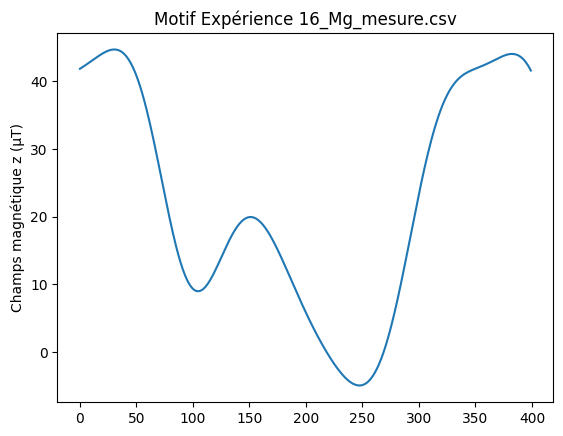

Reading 13_Mg_mesure.csv


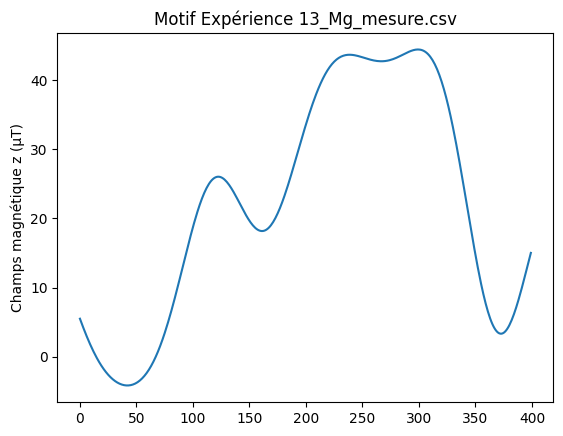

Reading 11_Mg_mesure.csv


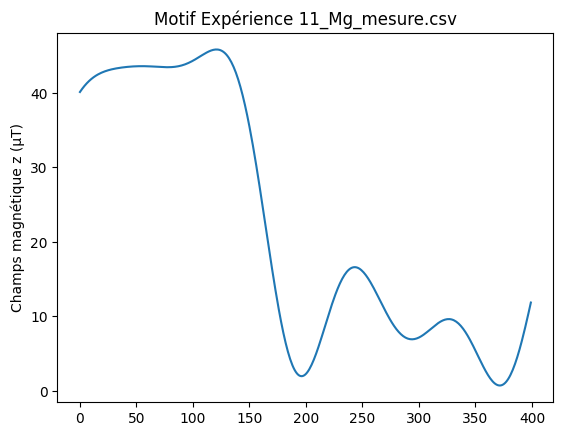

Reading 5_Mg_mesure.csv


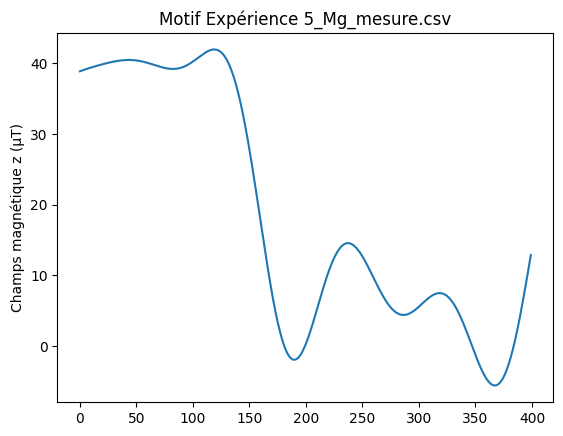

Reading 22_Mg_mesure.csv


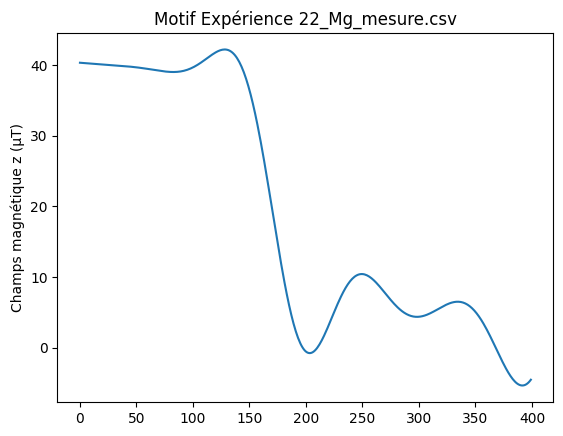

Reading 42_Mg_mesure.csv


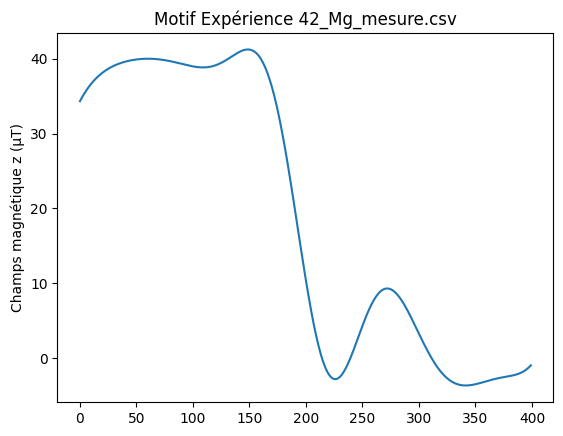

Reading 23_Mg_mesure.csv


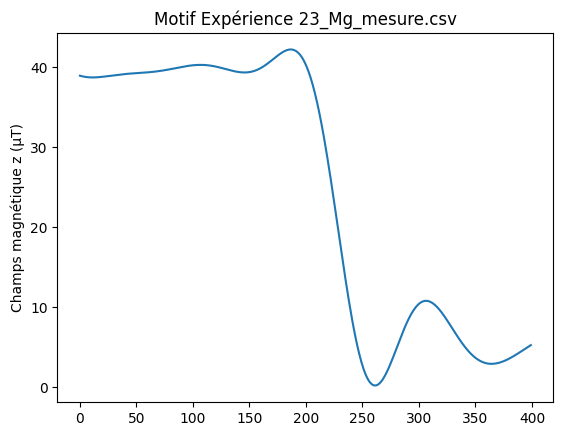

Reading 38_Mg_mesure.csv


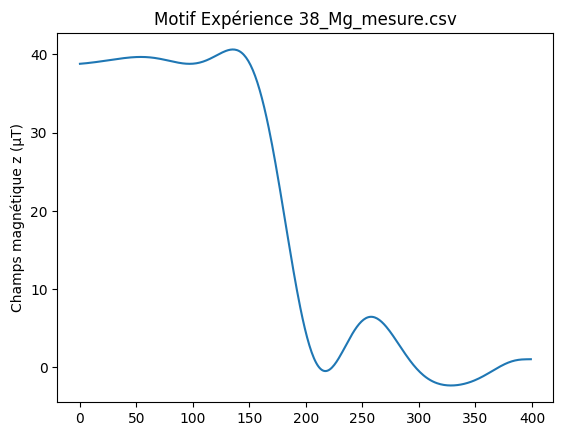

Reading 43_Mg_mesure.csv


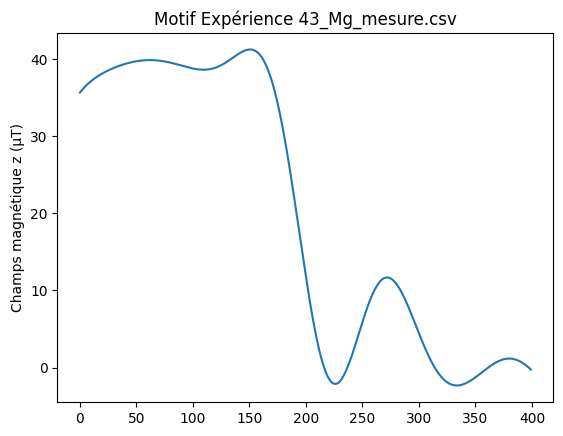

Reading 17_Mg_mesure.csv


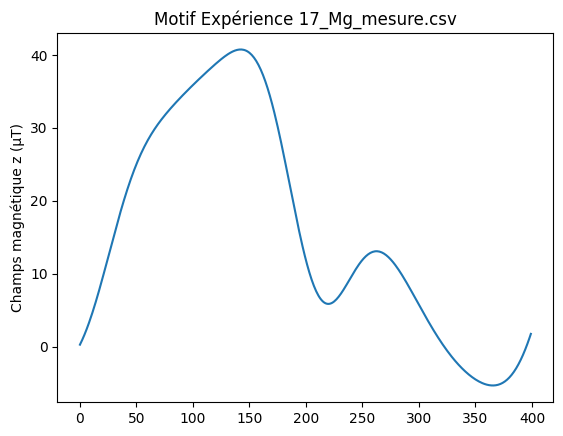

Reading 48_Mg_mesure.csv


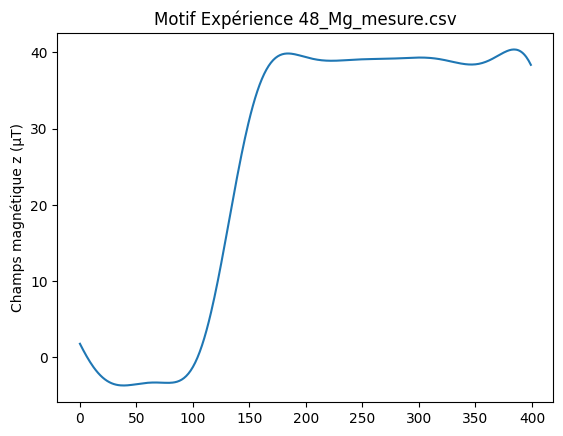

Reading 33_Mg_mesure.csv


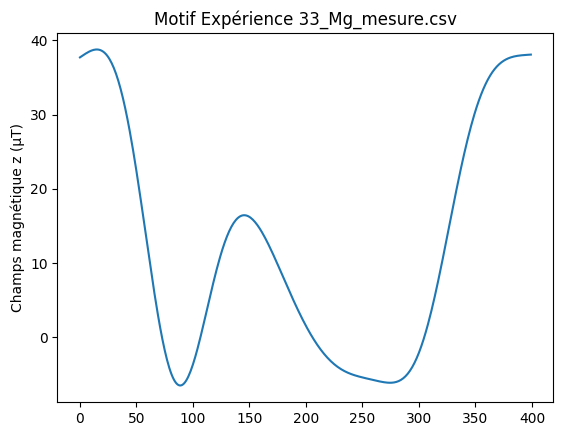

Reading 40_Mg_mesure.csv


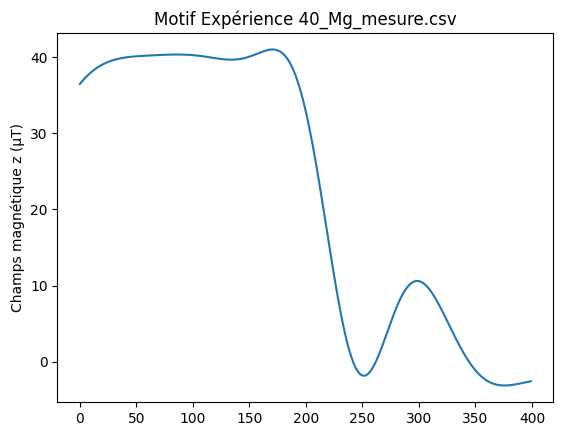

Reading 24_Mg_mesure.csv


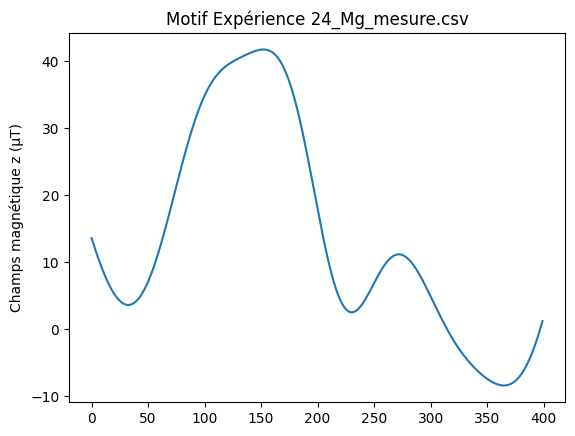

Reading 6_Mg_mesure.csv


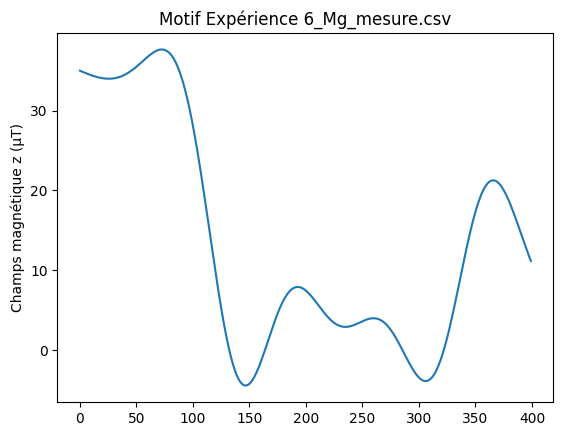

Reading 28_Mg_mesure.csv


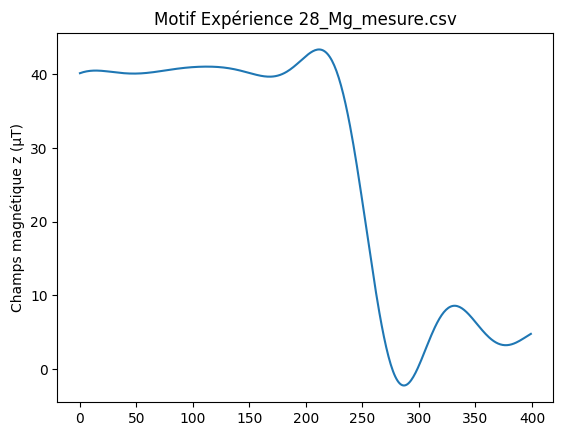

Reading 8_Mg_mesure.csv


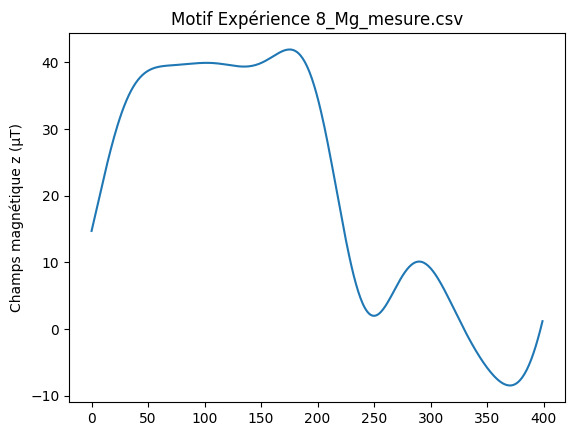

Reading 14_Mg_mesure.csv


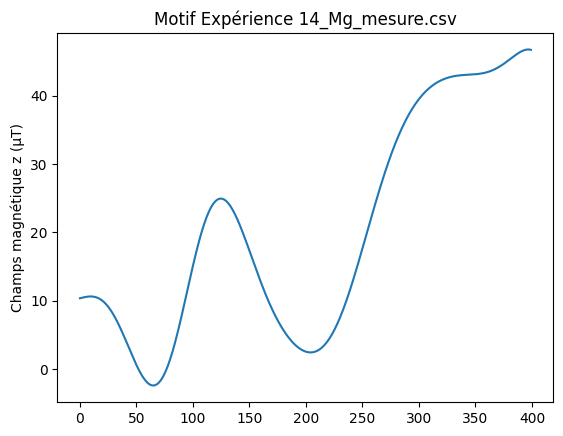

Reading 29_Mg_mesure.csv


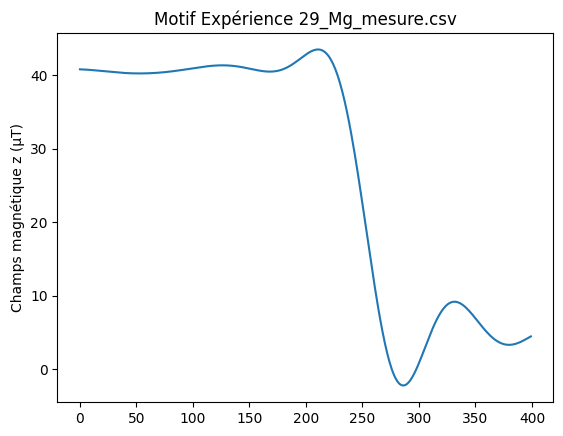

Reading 46_Mg_mesure.csv


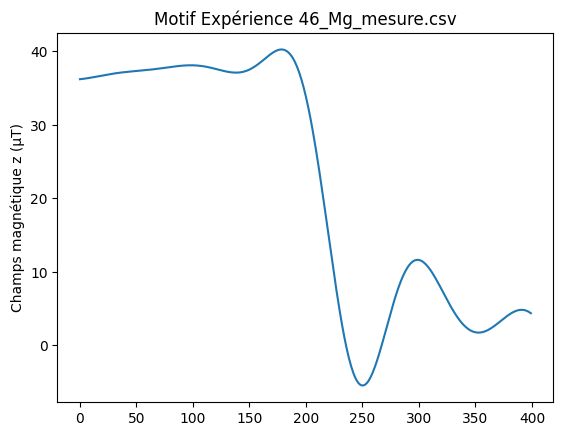

Reading 1_Mg_mesure.csv


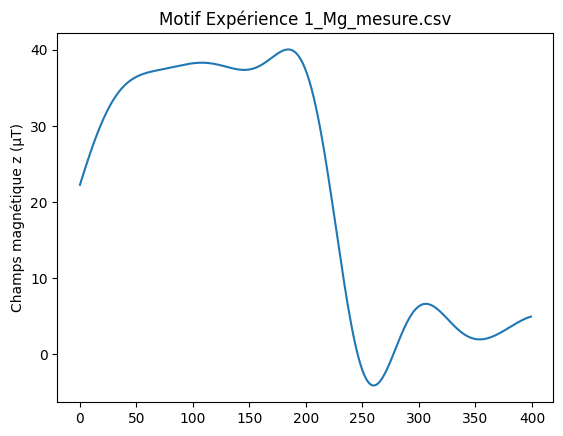

Reading 12_Mg_mesure.csv


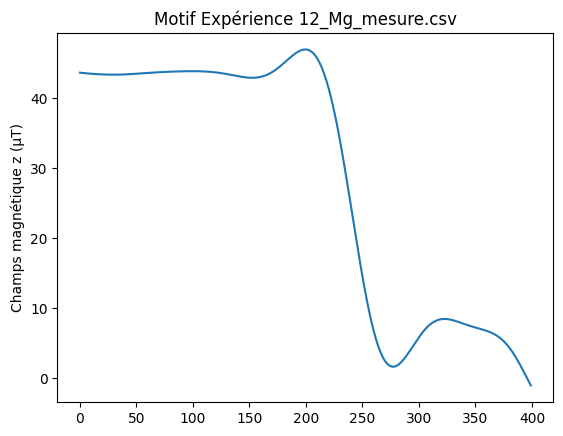

Reading 30_Mg_mesure.csv


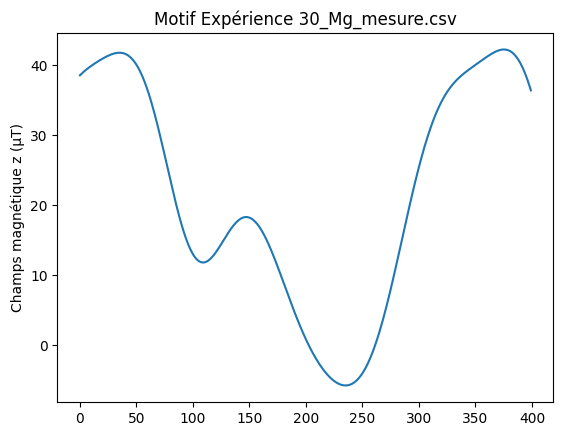

Reading 51_Mg_mesure.csv


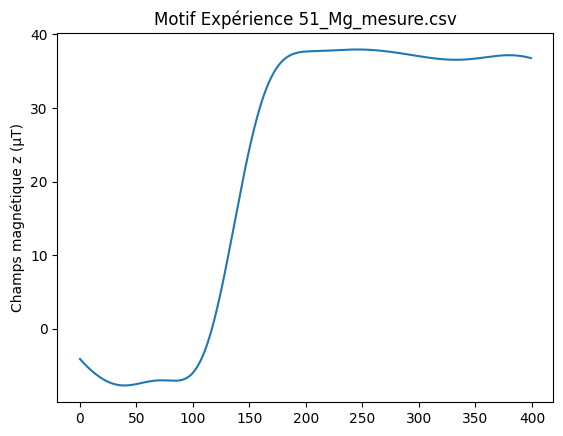

Reading 49_Mg_mesure.csv


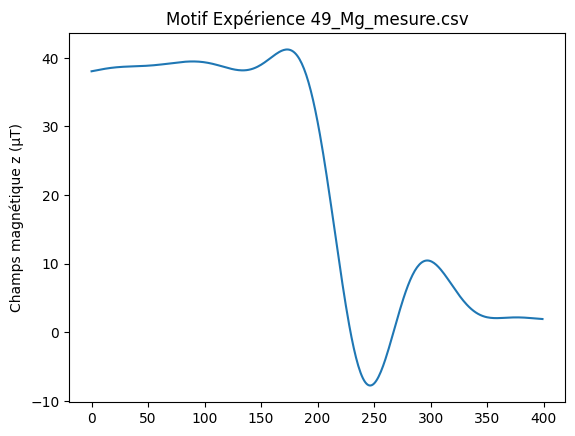

Reading 27_Mg_mesure.csv


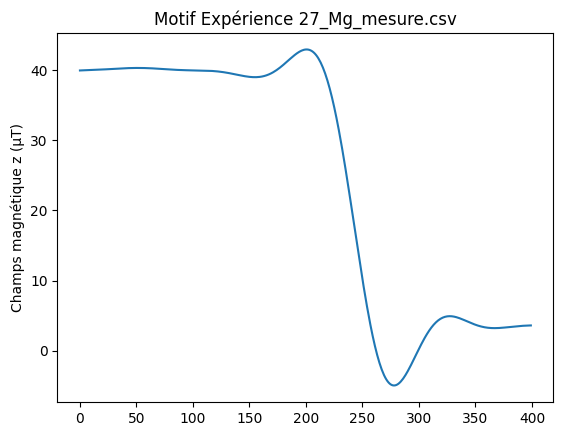

Reading 41_Mg_mesure.csv


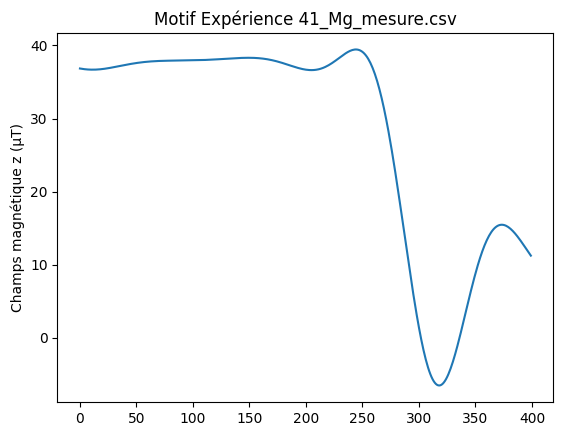

Reading 9_Mg_mesure.csv


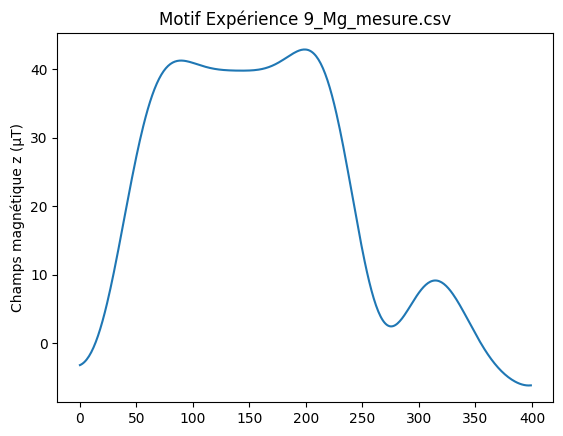

Reading 2_Mg_mesure.csv


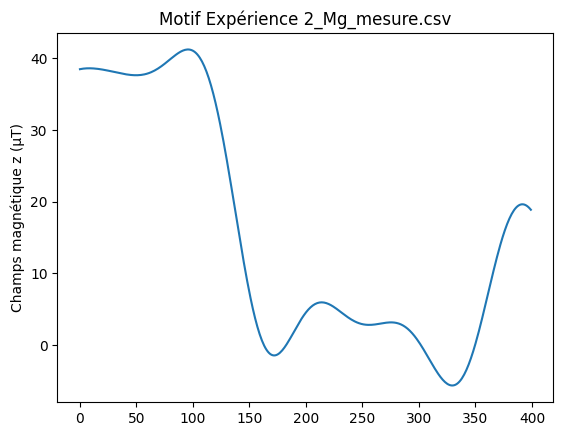

Reading 32_Mg_mesure.csv


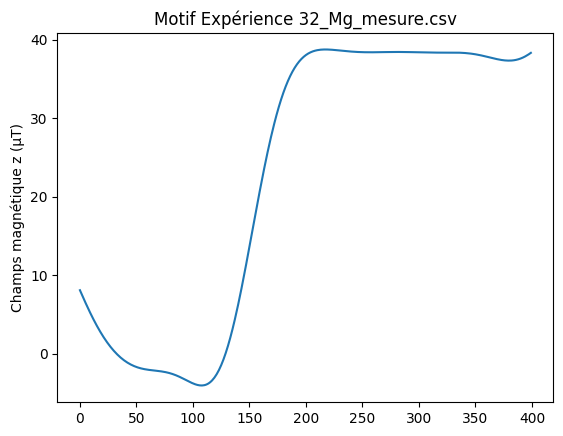

Reading 10_Mg_mesure.csv


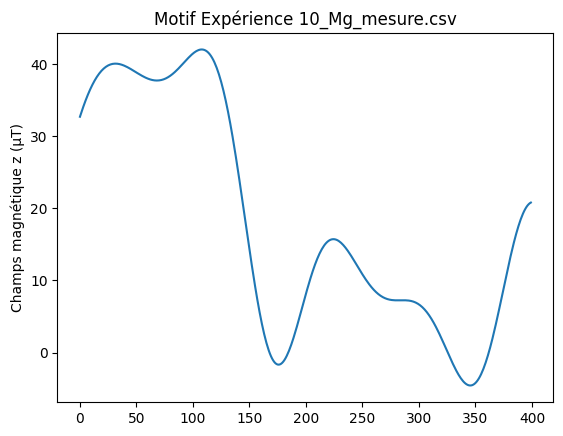

Reading 37_Mg_mesure.csv


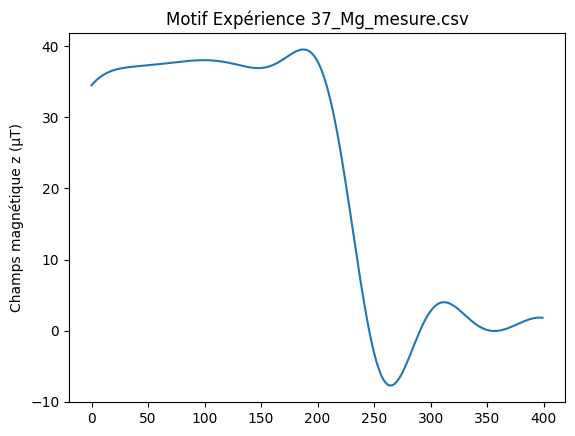

Reading 31_Mg_mesure.csv


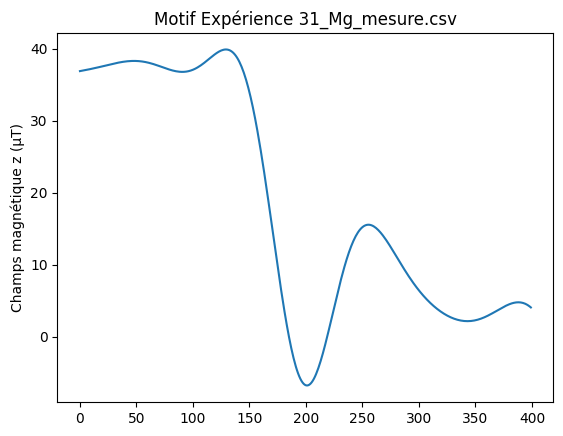

Reading 39_Mg_mesure.csv


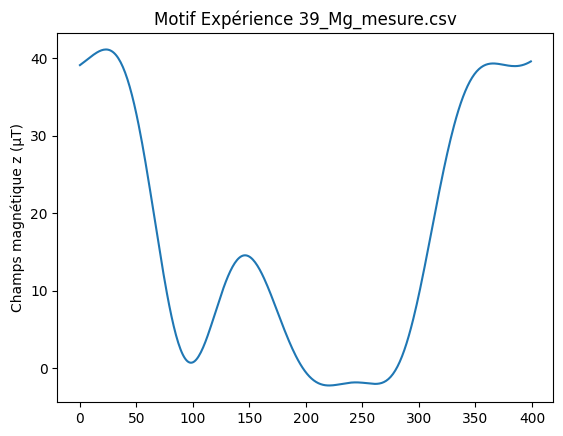

Reading 34_Mg_mesure.csv


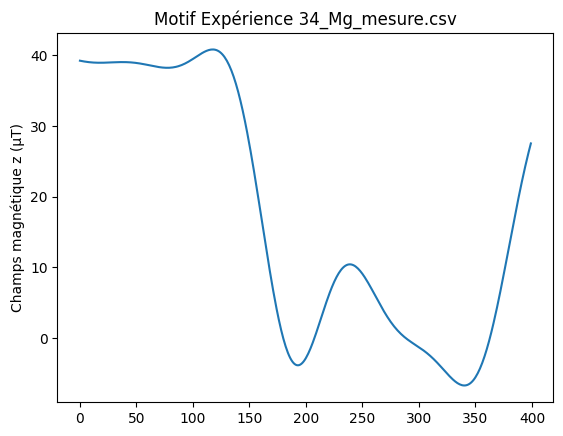

Reading 19_Mg_mesure.csv


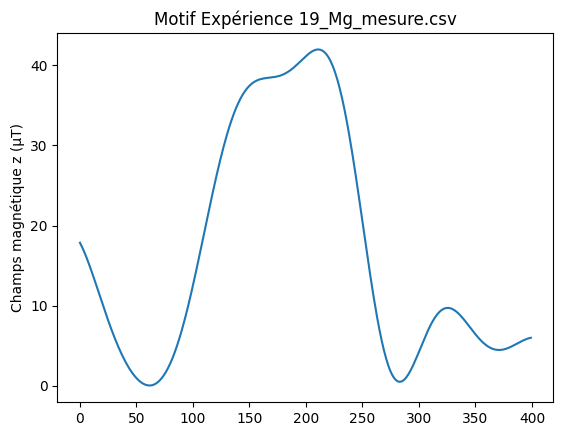

Reading 25_Mg_mesure.csv


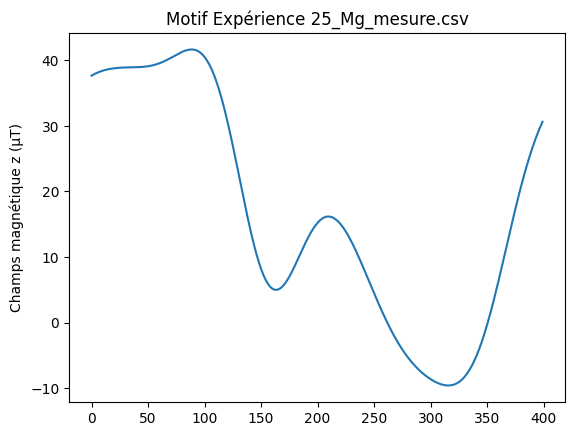

Reading 3_Mg_mesure.csv


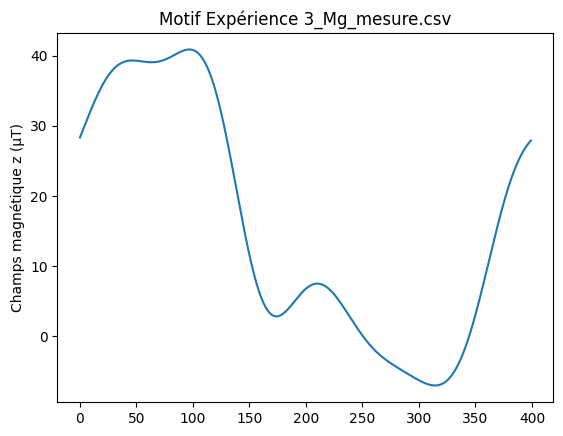

Reading 47_Mg_mesure.csv


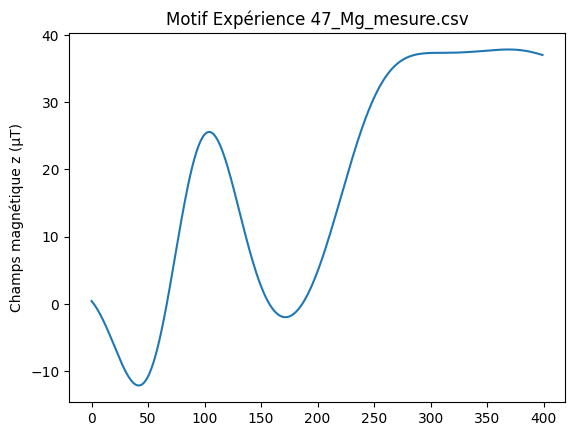

Reading 7_Mg_mesure.csv


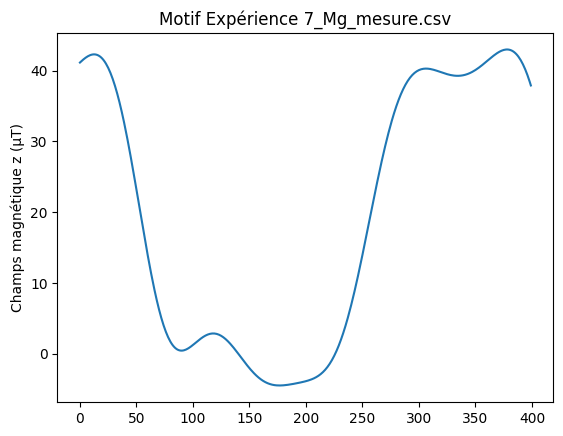

Reading 20_Mg_mesure.csv


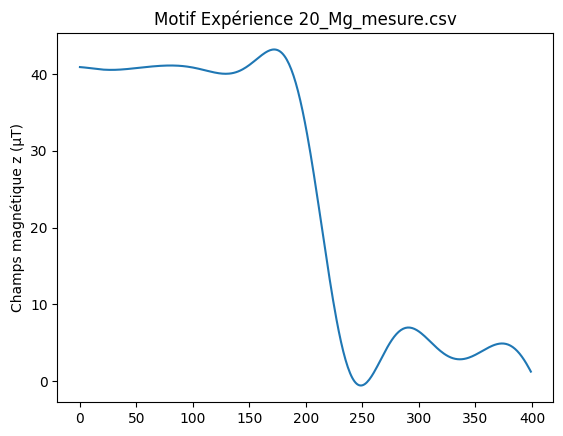

Reading 15_Mg_mesure.csv


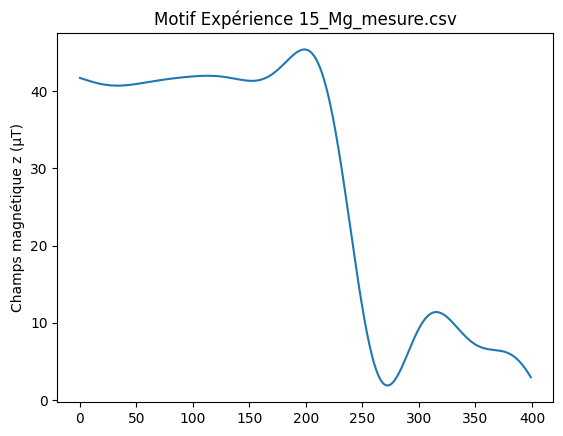

Reading 18_Mg_mesure.csv


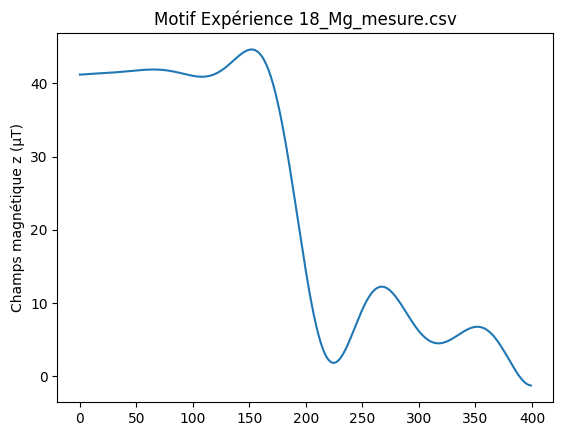

Reading 36_Mg_mesure.csv


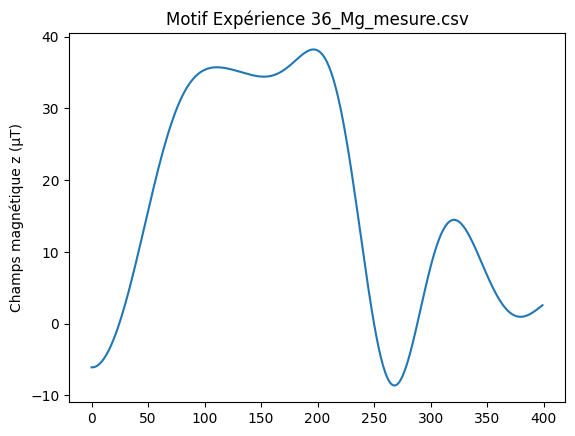

Reading 35_Mg_mesure.csv


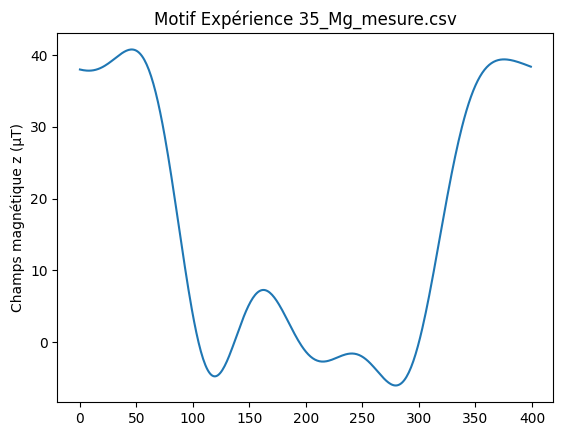

Reading 45_Mg_mesure.csv


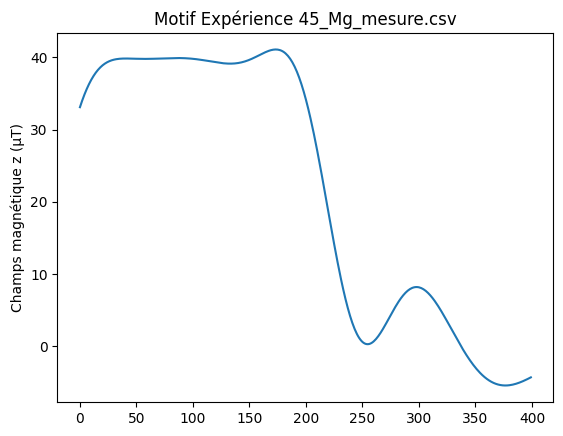

Reading 21_Mg_mesure.csv


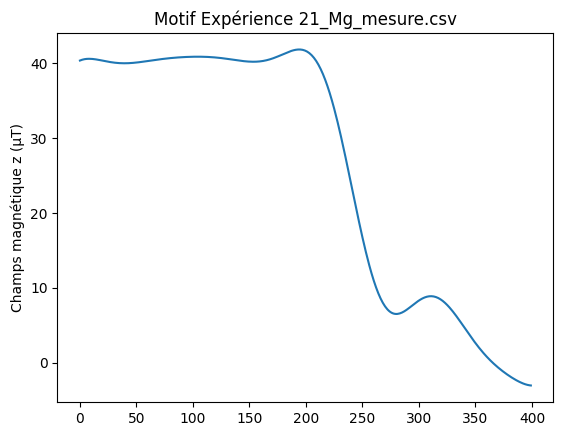

Reading 44_Mg_mesure.csv


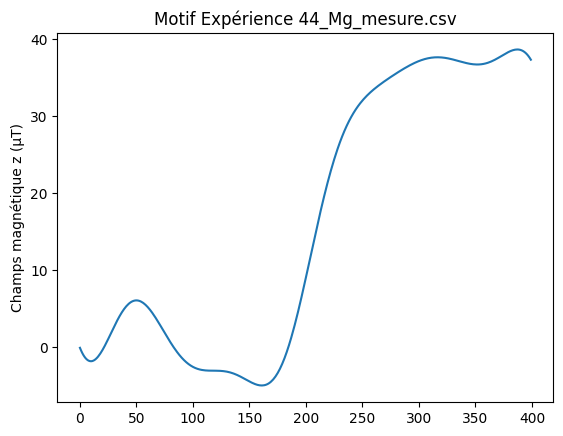

Reading 26_Mg_mesure.csv


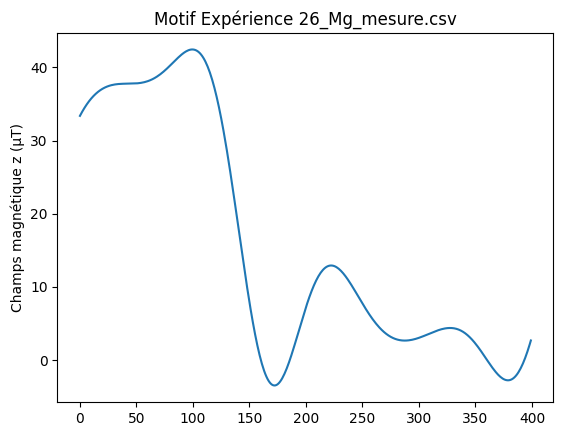

Reading 4_Mg_mesure.csv


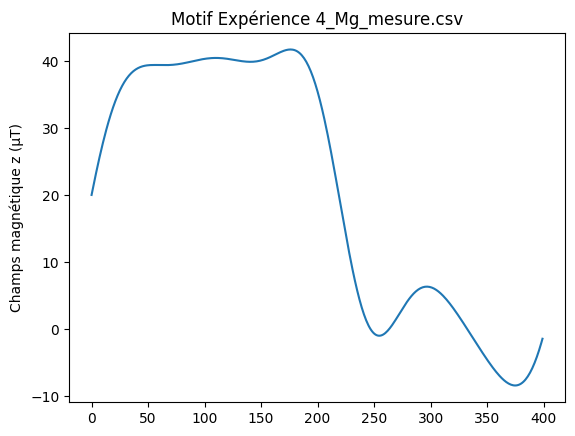

Reading 50_Mg_mesure.csv


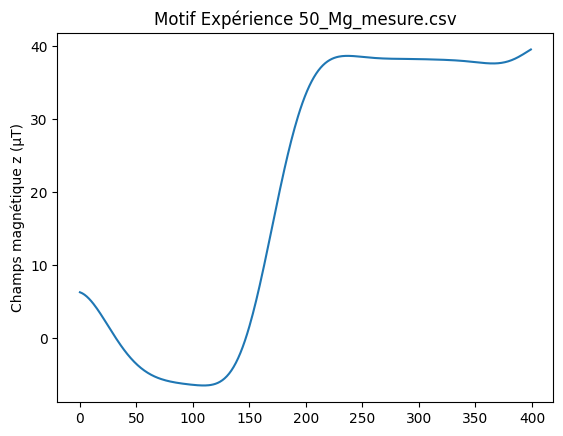

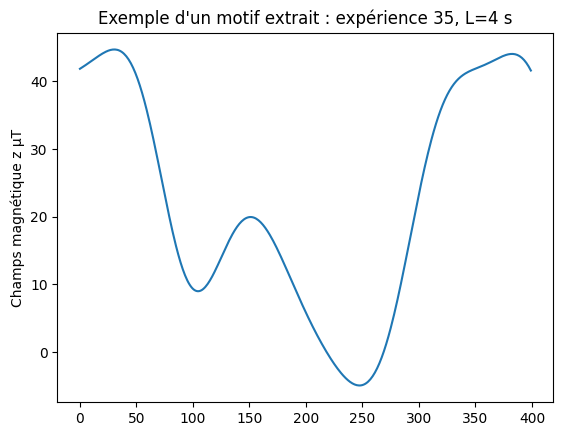

In [11]:
        # Librairies & constants
from scipy import signal
import numpy as np
from scipy.spatial import distance
from scipy.signal import find_peaks
from scipy.spatial.distance import euclidean
L=400
        # Used functions
def fast_distance_profile_nEUC(x,p):
    c=np.cumsum(np.concatenate(([0],x)))
    c2=np.cumsum(np.concatenate(([0],x))**2)
    N=np.size(x)
    Np=np.size(p)
    p_=(p-np.mean(p))/np.std(p)
    p__=np.zeros((N,))
    p__[0:Np]=np.flip(p_)
    r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
    vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
    d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
    return d
def matrix_profile(x,w):
    N=x.shape[0]
    d=np.inf*np.ones((N-w,))
    for i in range(N-w):
      x_=x[i:i+w]
      c=fast_distance_profile_nEUC(x,x_)
      c[np.maximum(0,int(i-w)):np.minimum(N-w,int(i+w))]=np.inf
      d=np.minimum(d,c)
    return d
def matrix_profile_pattern_nEUc(x2,L):
    #matrix profile using nEUc for distance comparison
    m=matrix_profile(x2,L)
    N=x2.shape[0]
    ind=np.argmin(m)
    #pattern extraction
    p=x2[ind:ind+L]
    return p
pattern_stacked=[]
N=len(Liste3)
for i in range(N):
    name=Liste3['name'].iloc[i]
    print(f"Reading {name}")
    x=Liste3['x'].iloc[i]
    t=Liste3['t'].iloc[i]
    p=matrix_profile_pattern_nEUc(x,L)
    pattern_stacked.append(p)
pattern_stacked=np.array(pattern_stacked)
plt.plot(pattern_stacked[0])
plt.ylabel('Champs magnétique z µT')
plt.title("Exemple d'un motif extrait : expérience 35, L=4 s")
plt.show()


# Sélection de features non supervisée par PCA

(51, 400)
(3, 51)


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(


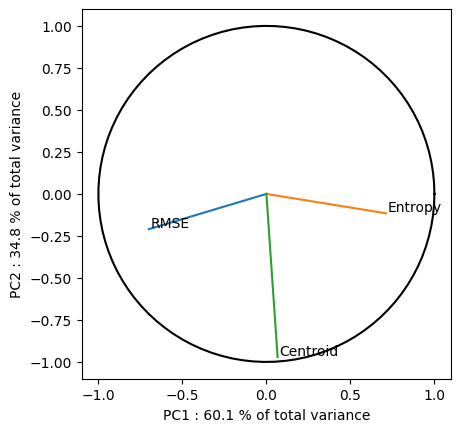

Feature  Centroid  :  0.973236654516264
Feature  RMSE  :  0.7303965413777125
Feature  Entropy  :  0.7206464505216588


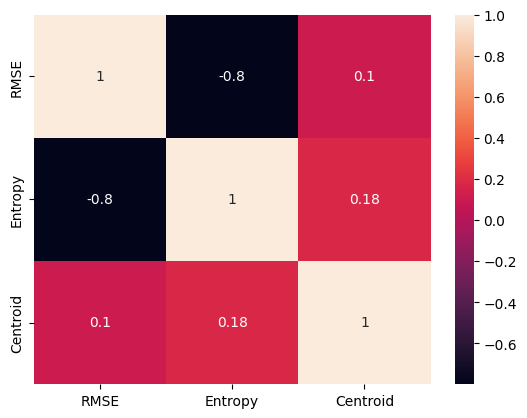

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from librosa.feature import spectral_centroid
import seaborn as sns

def plot_correlation_circle(U,feature_names,var_exp):
    D,D=np.shape(U)
    figure, axes = plt.subplots()
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()

def spectral_entropy(x, Fs):
    N = len(x)
    X = np.fft.fft(x)
    P = np.abs(X[:N//2])**2
    # Check if the sum of power is zero before dividing
    sum_P = np.sum(P)
    if sum_P == 0:
        return 0.0
    P = P / sum_P
    entropy = -np.sum(P * np.log2(P + 1e-12))
    # Check if log2(len(P)) is zero before dividing
    log_len_P = np.log2(len(P))
    if log_len_P == 0:
      return 0.0
    entropy_norm = entropy / log_len_P
    return entropy_norm
def compute_features(X):
    N,M=np.shape(X)
    Y=np.zeros((3,M))
    for i in range(M):
        centroid = spectral_centroid(y=X[:, i], sr=1)[0, 0]
        Y[0,i]=np.sqrt(np.sum(X[:,i]**2))
        Y[2, i] = centroid / (Fs/2) if Fs > 0 else 0.0
        Y[1,i]=spectral_entropy(X[:,i],Fs)
    return Y
print(np.shape(pattern_stacked))
Y = compute_features(np.transpose(pattern_stacked))
print(np.shape(Y))
def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        # Handle potential division by zero when standardizing
        std_dev = np.std(X[d,:])
        if std_dev == 0:
            X_[d,:] = 0
        else:
            X_[d,:]=(X[d,:]-np.mean(X[d,:]))/std_dev
    # Replace any NaN or inf values with 0 before SVD
    X_ = np.nan_to_num(X_, nan=0.0, posinf=0.0, neginf=0.0)
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

feature_names = [
  'RMSE',
   "Entropy","Centroid"]
plot_correlation_circle(U,feature_names,var_exp)
# Norm computation for each feature
score=np.sqrt(U[:,0]**2+U[:,1]**2)
ind = np.argsort(score)
ind=ind[::-1]

for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",score[ind[d]])
corr = np.corrcoef(Y)
sns.heatmap(corr, annot=True, xticklabels=feature_names, yticklabels=feature_names)
#plt.savefig(f"{Data_path}{feature_names[0]}_{feature_names[1]}__{feature_names[2]}_heatmap_L_4_0s.pdf")
plt.show()
Results=r"/content/Projet_Signal_ARIA_2025/Results"
np.savez(f"{Results}/Final_doc_{feature_names[0]}_{feature_names[1]}_{feature_names[2]}_L_4_0s.npz",RMSE=Y[0] ,Entropy=Y[1],Centroid=Y[2])
print(f"Les 3 osbervables ont été enregistrées dans le dossier {Results} sous format numpy compressé npz")

#Unsupervised clustering using scikit learn and k-means method
Le modèle est le modèle des 2-moyens (k=2) avec l'algorithme de Elkan. Pour évaluer sa fiabilité, le score Silhouette=$\frac{b-a}{\max(b,a)}$
Un score Silhouette inférieur lors du test indique une diminution de la séparativité des données par le modèle. \
Un score Silhouette négatif semble peu vraisemblable pendant l'entraînement, puisque cela signifie que la distance entre clusters est plus petite que la distance entre points d'un même cluster. Le clustering ne se fait pas sur les motifs de 400 points (même si c'est théoriquement possible) mais sur les 3 observables précédemment computées : RMSE, Entropie de spectre et Centroïde de spectre.

51
3
35 35
16 16
Initialization complete
Iteration 0, inertia 63787.15316955841
Iteration 1, inertia 58771.65304981807
Converged at iteration 1: strict convergence.
Nombre de classe 0 in training:  19
Nombre de classe 1 in training :  16
score=0.5670062464816188
Nombre de classe 0 in total:  26
Nombre de classe 1 in total:  25
testing score : 0.4451422995634796


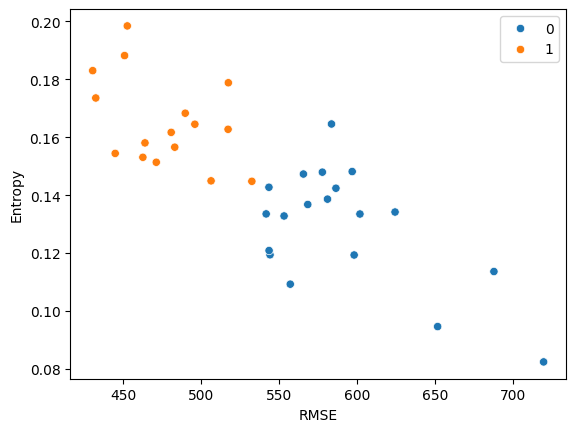

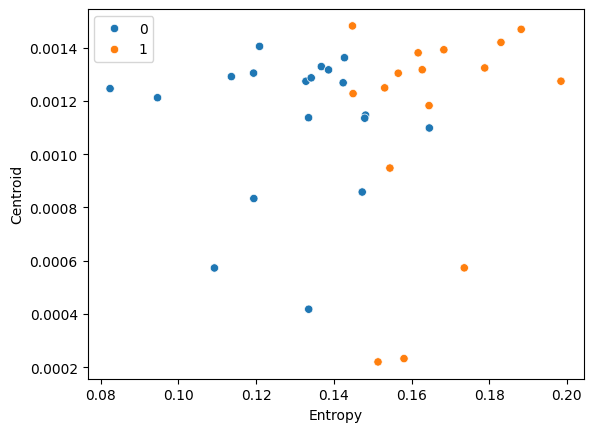

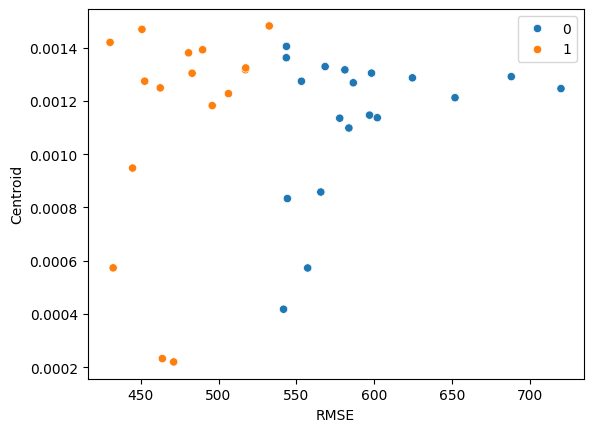

In [ ]:
!pip install scikit-learn
from sklearn.cluster import KMeans
import random as rd
import pandas as pd # Import pandas
trois,N=np.shape(Y)
print(N)
Z=np.transpose(Y)
print(len(Z[0]))
r=0.7
N_train=int(N*0.7)
N_test=N-N_train
X_train_list=[] # Rename X_train to X_train_list to avoid conflict
X_test_list=[] # Rename X_test to X_test_list to avoid conflict
for i in range(N):
  test=rd.random()
  if test<=r and len(X_train_list)<N_train: # Use X_train_list
    X_train_list.append(Z[i]) # Use X_train_list
  else:
    X_test_list.append(Z[i]) # Use X_test_list
print(N_train,len(X_train_list)) # Use X_train_list
print(N_test,len(X_test_list)) # Use X_test_list

# Convert lists to pandas DataFrames
X_train_df = pd.DataFrame(X_train_list, columns=feature_names) # Use X_train_list and feature_names
X_test_df = pd.DataFrame(X_test_list, columns=feature_names) # Use X_test_list and feature_names

K=KMeans(n_clusters=2, random_state=0, n_init="auto", verbose=2,algorithm='elkan')
K.fit(X_train_df) # Fit on DataFrame

# Use the DataFrame for plotting and specify actual column names
sns.scatterplot(data = X_train_df, x = feature_names[0], y = feature_names[1], hue = K.labels_)
plt.figure()
sns.scatterplot(data = X_train_df, x = feature_names[1], y = feature_names[2], hue = K.labels_)
plt.figure()
sns.scatterplot(data = X_train_df, x = feature_names[0], y = feature_names[2], hue = K.labels_)
N_0=np.sum(K.labels_==0)
print("Nombre de classe 0 in training: ", N_0)
N_1=np.sum(K.labels_==1)
print("Nombre de classe 1 in training : ",N_1)
from sklearn.metrics import silhouette_score
score=silhouette_score(X_train_df, K.labels_, metric='euclidean')
print(f"score={score}")
## testing on unseen data during training
test_labels = K.predict(X_test_df)
N_0_test=np.sum(test_labels==0)
N_1_test=np.sum(test_labels==1)
print("Nombre de classe 0 in total: ", N_0+N_0_test)
print("Nombre de classe 1 in total: ", N_1+N_1_test)
test_score= silhouette_score(X_test_df, test_labels, metric='euclidean')
print(f"testing score : {test_score}")